In [17]:
import gradio as gr
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch import torch
from torch.nn import functional as F


import gradio as gr
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch import torch
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from script.functions import evaluate_email, evaluate_email_list
import matplotlib.pyplot as plt

input_model_path = "/home/lujun_li/projects/temperature_eval/bert_model_target_2"
tokenizer_path = "/home/lujun_li/models/bert-base-multilingual-uncased"

dataset_path = (
    "/home/lujun_li/projects/temperature_eval/data/all_data_for_bert_training.csv"
)

# Load the dataset from a CSV file
dataset = pd.read_csv(dataset_path)
optimal_temps = (
    dataset.groupby(["model_name", "ability", "Temperature"])["performance_score"]
    .mean()
    .reset_index()
)

scaler = MinMaxScaler()
optimal_temps["normalized_score"] = optimal_temps.groupby("ability")[
    "performance_score"
].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())


def find_performance_score(df, model_name, ability, Temperature):
    """
    Find the performance_score for a specific combination of model_name, ability, and Temperature.

    Parameters:
    - df: pandas DataFrame containing the data
    - model_name: the model_name you are interested in
    - ability: the ability you are interested in
    - Temperature: the Temperature you are interested in

    Returns:
    - The performance_score for the specified combination, or None if not found.
    """

    # Step 1: Filter the DataFrame based on the input conditions
    result = df[
        (df["model_name"] == model_name)
        & (df["ability"] == ability)
        & (df["Temperature"] == Temperature)
    ]

    # Step 2: Return the performance_score or None if no matching row is found
    if not result.empty:
        return result["performance_score"].iloc[
            0
        ]  # Return the first matching performance_score
    else:
        return None  # Return None if no matching row is found


def get_best_temperature(
    input_text,
    input_model_path,
    input_model_name,
    tokenizer_path,
    input_distribution_df,
):

    output, prob_dict = evaluate_email(
        input_text=input_text,
        input_model_name=input_model_name,
        model_path=input_model_path,
        tokenizer_path=tokenizer_path,
        max_padding=512,
    )
    best_temperature = None
    best_score = 0
    for temp in input_distribution_df["Temperature"].unique().tolist():
        score = 0
        for ability, probability in prob_dict.items():
            score += probability * find_performance_score(
                input_distribution_df, input_model_name, ability, temp
            )
        if score > best_score:
            best_score = score
            best_temperature = temp
    return best_temperature


def get_average_best_temperature(
    input_text_list,
    input_model_path,
    input_model_name,
    tokenizer_path,
    input_distribution_df,
):
    best_temperatures = []

    for input_text in input_text_list:
        # Evaluate the email and get the probability distribution
        output, prob_dict = evaluate_email(
            input_text=input_text,
            input_model_name=input_model_name,
            model_path=input_model_path,
            tokenizer_path=tokenizer_path,
            max_padding=512,
        )

        # Initialize variables to track the best temperature
        best_temperature = None
        best_score = 0

        # Iterate over all unique temperatures in the dataframe
        for temp in input_distribution_df["Temperature"].unique().tolist():
            score = 0
            for ability, probability in prob_dict.items():
                # Calculate the performance score
                score += probability * find_performance_score(
                    input_distribution_df, input_model_name, ability, temp
                )
            # Update the best score and temperature if a better one is found
            if score > best_score:
                best_score = score
                best_temperature = temp

        # Add the best temperature for this text to the list
        if best_temperature is not None:
            best_temperatures.append(best_temperature)

    # Calculate and return the average of the best temperatures
    if best_temperatures:
        return sum(best_temperatures) / len(best_temperatures)
    else:
        return None  # Return None if no best temperatures were found


import requests
import json


def on_experiment_button_click(
    input_text,
    best_temperature,
    input_model="llama2-7b",
    input_api="http://localhost:11434/api/generate",
):
    url = input_api

    headers = {"Content-Type": "application/json"}

    # The data you want to send in the request body
    data = {
        "model": "llama3.2:3b",
        "prompt": input_text,
        "stream": False,
        "temperature": best_temperature,
    }

    # Send a POST request
    response = requests.post(url, headers=headers, data=json.dumps(data))
    print(response)
    if response.status_code == 200:
        response_json = response.json()  # Parse the JSON response
        return response_json.get(
            "response", None
        )  # Get the 'responses' key, or None if not present
    else:
        return f"Error: {response.status_code}"


def on_button_click(input_text, input_file, input_model):
    result_text = f"The input is: {input_text}"
    output_text = ""
    label_probs = None  # Initialize label_probs in case input_text is empty

    if input_file is not None:
        df = pd.read_csv(input_file.name)
        print(input_file.name)
        file_result = df
    else:
        file_result = None

    result_model = f"The model you choose is: {input_model}"

    # If text input is provided, classify it
    if input_text:
        output_dist_ability, prob_dict = evaluate_email(
            input_text=input_text,
            input_model_name=input_model,
            model_path=input_model_path,
            tokenizer_path=tokenizer_path,
            max_padding=512,
        )
        best_temperature = get_best_temperature(
            input_text=input_text,
            input_model_path=input_model_path,
            input_model_name=input_model,
            tokenizer_path=tokenizer_path,
            input_distribution_df=optimal_temps,
        )
    if input_file:
        input_texts = df["input"].tolist()
        output_dist_ability, prob_dict = evaluate_email_list(
            input_text_list=input_texts,
            input_model_name=input_model,
            model_path=input_model_path,
            tokenizer_path=tokenizer_path,
            max_padding=512,
        )
        best_temperature = get_average_best_temperature(
            input_text_list=input_texts,
            input_model_path=input_model_path,
            input_model_name=input_model,
            tokenizer_path=tokenizer_path,
            input_distribution_df=optimal_temps,
        )

    prob_list = list(prob_dict.items())
    class_labels = [item[0] for item in prob_list]  # Extract labels (keys)
    probabilities = [item[1] for item in prob_list]  # Extract values (probabilities)

    colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]

    # Create pie chart with improved aesthetics
    fig, ax = plt.subplots(
        figsize=(5, 5)
    )  # Set the figure size for better visual appeal
    ax.pie(
        probabilities,
        labels=class_labels,
        autopct="%1.2f%%",
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "black", "linewidth": 1.5},
        textprops={"fontsize": 7, "fontweight": "bold"},
    )

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis("equal")

    # Add a title
    ax.set_title("Class Distribution", fontsize=16, fontweight="bold")

    return fig, best_temperature, best_temperature


choices = [
    "General-Settings",
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]


with gr.Blocks() as demo:

    gr.HTML(
        "<div style='text-align: left;'>"
        "<span style='color: gray; font-size: 25px; font-weight: bold;'>This is the first section where you can input and analyze data.</span><br>"
        "<span style='color: gray; font-size: 12px;'><small>This section allows you to upload your data, which will be processed and analyzed for insights.</small></span>"
        "</div>"
    )
    with gr.Row():
        with gr.Column(scale=0.5):
            input_text_box = gr.Textbox(label="Input Text", elem_id="input_text")
            input_file_box = gr.File(
                label="Input File",
                elem_id="input_file",
                elem_classes="small-input-file",
            )

            input_model_radio = gr.Radio(
                choices=choices,
                label="Select Model",
                elem_id="input_model",
                value=choices[0],
                interactive=True,
            )
        with gr.Column(scale=0.5):
            # file_analysis_output_box = gr.Textbox(
            #     label="File Analysis Output",
            #     elem_id="file_analysis_output",
            #     interactive=False,
            # )
            cls_label_output_box = gr.Plot(
                label="Class Label Output (Pie Chart)",
                elem_id="cls_label_output",
            )

            best_temperature_output_box = gr.Textbox(
                label="Best Temperature Output",
                elem_id="best_temperature_output",
                interactive=False,
            )
    with gr.Row():
        with gr.Column(scale=1.0):
            input_button = gr.Button("Analyze", elem_id="input_button")

    gr.HTML(
        "<div style='text-align: left;'>"
        "<span style='color: gray; font-size: 25px; font-weight: bold;'>Recommendation section</span><br>"
        "<span style='color: gray; font-size: 12px;'><small>Give you the best temperature settings according to your input or prompts</small></span>"
        "</div>"
    )
    gr.HTML("<hr>")

    with gr.Row():  # 第二行
        with gr.Column(scale=1):
            input_temperature_slider = gr.Slider(
                minimum=0,
                maximum=2.0,
                step=0.1,
                label="Input Temperature",
                elem_id="input_temperature",
            )
            input_api_box = gr.Textbox(
                label="API Key",
                elem_id="input_api",
                value="http://localhost:11434/api/generate",
            )
            start_experiment_button = gr.Button(
                "Start Experiment", elem_id="start_experiment"
            )

    gr.HTML(
        "<div style='text-align: left;'>"
        "<span style='color: gray; font-size: 25px; font-weight: bold;'>Outputs</span><br>"
        "<span style='color: gray; font-size: 12px;'><small>The output files and analysis</small></span>"
        "</div>"
    )
    gr.HTML("<hr>")
    with gr.Row():
        output_text_box = gr.Textbox(
            label="Output Text", elem_id="output_text", lines=10, interactive=False
        )
        download_results = gr.Button("Download Results", elem_id="download_results")

    input_button.click(
        on_button_click,
        inputs=[input_text_box, input_file_box, input_model_radio],
        outputs=[
            cls_label_output_box,
            best_temperature_output_box,
            input_temperature_slider,
        ],
    )

    start_experiment_button.click(
        on_experiment_button_click,
        inputs=[
            input_text_box,
            input_temperature_slider,
            input_model_radio,
            input_api_box,
        ],
        outputs=[output_text_box],
    )
demo.launch(share=False)

/home/lujun_li/anaconda3/envs/causalLLM/lib/python3.10/site-packages/gradio/layouts/column.py:55: UserWarning: 'scale' value should be an integer. Using 0.5 will cause issues.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.


/home/lujun_li/projects/temperature_eval/script/functions.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Truncation was not explicitly a

Model loaded and set to evaluation mode.
pred_flat : [[0.04843811 0.05790919 0.04723765 0.21042465 0.18145293 0.45453745]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.05 IF: 0.21 MT: 0.18 SUM: 0.45 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04843811 0.05790919 0.04723765 0.21042465 0.18145293 0.45453745]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.05 IF: 0.21 MT: 0.18 SUM: 0.45 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04843811 0.05790919 0.04723765 0.21042465 0.18145293 0.45453745]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.05 IF: 0.21 MT: 0.18 SUM: 0.45 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04843811 0.05790919 0.04723765 0.21042465 0.18145293 0.45453745]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.05 IF: 0.21 MT: 0.18 SUM: 0.45 
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
/tmp/gradio/d79713c3bcc7f95ee22db6be4b2f0fd9cedb7f165dc14aa00fd0203b4c5e95ce/MT.csv


/home/lujun_li/projects/temperature_eval/script/functions.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Truncation was not explicitly 

Model loaded and set to evaluation mode.


/home/lujun_li/anaconda3/envs/causalLLM/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/lujun_li/projects/temperature_eval/script/functions.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default

Model loaded and set to evaluation mode.
pred_flat : [[0.05625881 0.05869779 0.06583516 0.22339797 0.3485374  0.2472729 ]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.06 CT: 0.06 ICL: 0.07 IF: 0.22 MT: 0.35 SUM: 0.25 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.08581232 0.08658184 0.10501351 0.17850378 0.3838842  0.16020435]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.09 ICL: 0.11 IF: 0.18 MT: 0.38 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.0395022  0.04478537 0.03703306 0.14538698 0.60893154 0.12436085]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.04 CT: 0.04 ICL: 0.04 IF: 0.15 MT: 0.61 SUM: 0.12 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04413209 0.05749002 0.05179596 0.6283982  0.09331544 0.12486832]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.04 CT: 0.06 ICL: 0.05 IF: 0.63 MT: 0.09 SUM: 0.12 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04413209 0.05749002 0.05179596 0.6283982  0.09331544 0.12486832]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.04 CT: 0.06 ICL: 0.05 IF: 0.63 MT: 0.09 SUM: 0.12 
<Response [200]>
<Response [200]>
<Response [200]>


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04413209 0.05749002 0.05179596 0.6283982  0.09331544 0.12486832]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.04 CT: 0.06 ICL: 0.05 IF: 0.63 MT: 0.09 SUM: 0.12 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04413209 0.05749002 0.05179596 0.6283982  0.09331544 0.12486832]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.04 CT: 0.06 ICL: 0.05 IF: 0.63 MT: 0.09 SUM: 0.12 


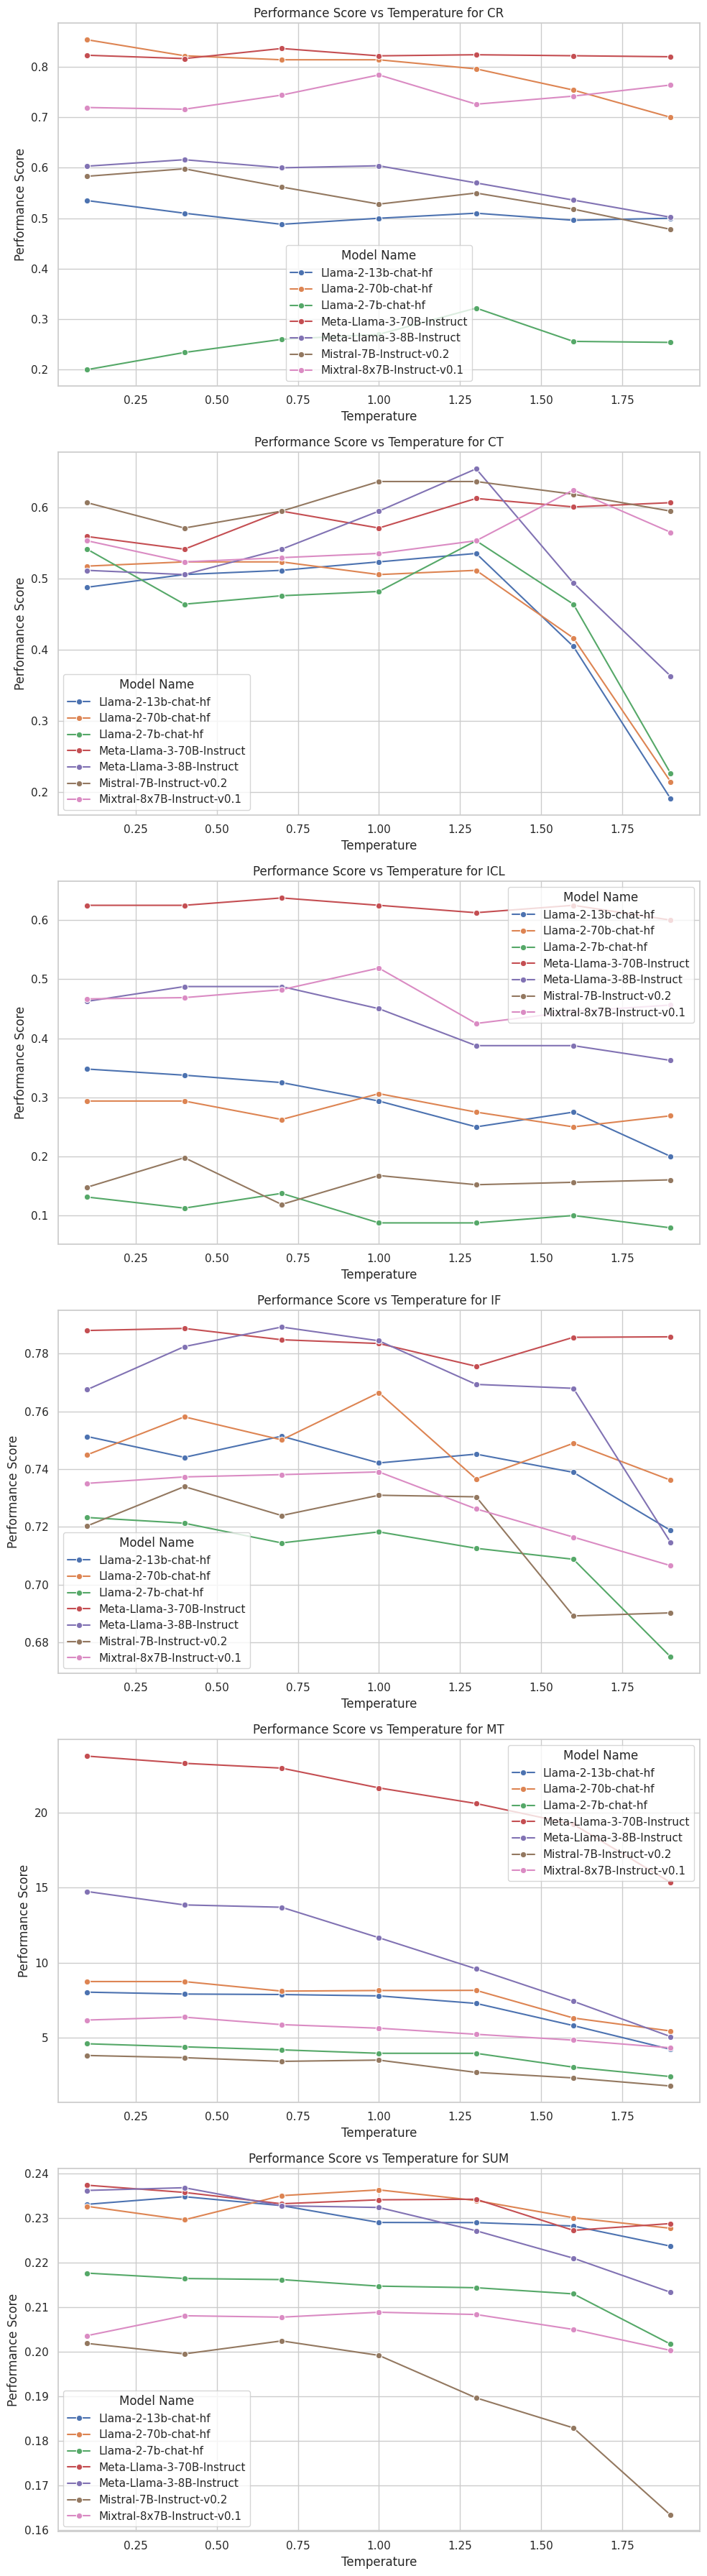

/home/lujun_li/projects/temperature_eval/script/functions.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Truncation was not explicitly a

Model loaded and set to evaluation mode.
pred_flat : [[0.02576031 0.03472482 0.03492359 0.7773499  0.06610924 0.06113217]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.03 ICL: 0.03 IF: 0.78 MT: 0.07 SUM: 0.06 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.02576031 0.03472482 0.03492359 0.7773499  0.06610924 0.06113217]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.03 ICL: 0.03 IF: 0.78 MT: 0.07 SUM: 0.06 
<Response [200]>


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.05145479 0.04135067 0.04277485 0.7292634  0.05533459 0.07982173]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.04 ICL: 0.04 IF: 0.73 MT: 0.06 SUM: 0.08 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.05145479 0.04135067 0.04277485 0.7292634  0.05533459 0.07982173]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.04 ICL: 0.04 IF: 0.73 MT: 0.06 SUM: 0.08 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.02576031 0.03472482 0.03492359 0.7773499  0.06610924 0.06113217]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.03 ICL: 0.03 IF: 0.78 MT: 0.07 SUM: 0.06 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.02576031 0.03472482 0.03492359 0.7773499  0.06610924 0.06113217]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.03 ICL: 0.03 IF: 0.78 MT: 0.07 SUM: 0.06 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.0705718  0.06005409 0.05881122 0.6199014  0.04875603 0.14190546]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.07 CT: 0.06 ICL: 0.06 IF: 0.62 MT: 0.05 SUM: 0.14 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.0705718  0.06005409 0.05881122 0.6199014  0.04875603 0.14190546]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.07 CT: 0.06 ICL: 0.06 IF: 0.62 MT: 0.05 SUM: 0.14 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.13744314 0.05861688 0.07975399 0.21560967 0.3644873  0.144089  ]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.14 CT: 0.06 ICL: 0.08 IF: 0.22 MT: 0.36 SUM: 0.14 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.13744314 0.05861688 0.07975399 0.21560967 0.3644873  0.144089  ]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.14 CT: 0.06 ICL: 0.08 IF: 0.22 MT: 0.36 SUM: 0.14 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.03137871 0.03653003 0.03445295 0.0615074  0.77271706 0.06341381]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.04 ICL: 0.03 IF: 0.06 MT: 0.77 SUM: 0.06 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.03137871 0.03653003 0.03445295 0.0615074  0.77271706 0.06341381]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.03 CT: 0.04 ICL: 0.03 IF: 0.06 MT: 0.77 SUM: 0.06 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.04883306 0.06441244 0.05836725 0.24703512 0.18202463 0.39932746]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.05 CT: 0.06 ICL: 0.06 IF: 0.25 MT: 0.18 SUM: 0.40 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.12666345 0.05543713 0.05652821 0.38813558 0.12311256 0.25012302]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.13 CT: 0.06 ICL: 0.06 IF: 0.39 MT: 0.12 SUM: 0.25 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.12666345 0.05543713 0.05652821 0.38813558 0.12311256 0.25012302]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.13 CT: 0.06 ICL: 0.06 IF: 0.39 MT: 0.12 SUM: 0.25 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model loaded and set to evaluation mode.
pred_flat : [[0.09207666 0.04725669 0.04924165 0.47598246 0.17521344 0.16022915]]
labels_flat : [[0 1 2 3 4 5]]
mapping: {0: 'CR', 1: 'CT', 2: 'ICL', 3: 'IF', 4: 'MT', 5: 'SUM'}
CR: 0.09 CT: 0.05 ICL: 0.05 IF: 0.48 MT: 0.18 SUM: 0.16 
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

abilities = optimal_temps["ability"].unique()
sns.set(style="whitegrid")

fig, axes = plt.subplots(len(abilities), 1, figsize=(10, 6 * len(abilities)))

if len(abilities) == 1:
    axes = [axes]

for idx, ability in enumerate(abilities):
    ax = axes[idx]
    ability_data = optimal_temps[optimal_temps["ability"] == ability]

    sns.lineplot(
        x="Temperature",
        y="performance_score",
        hue="model_name",
        data=ability_data,
        ax=ax,
        marker="o",
    )

    ax.set_title(f"Performance Score vs Temperature for {ability}")
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Performance Score")
    ax.legend(title="Model Name")

plt.tight_layout()

plt.show()